<a href="https://colab.research.google.com/github/gautamprakash2102/Lung-Cancer-Classification/blob/main/CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries and Data

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
data_dir = '/content/drive/MyDrive/CNN_Model'
dataset = ImageFolder(data_dir, transform=ToTensor())

In [ ]:
print(dataset.classes)

['New_Normal', 'New_Tumour']


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  New_Normal (0)


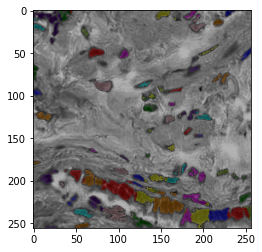

In [ ]:
show_example(*dataset[0])

#Training and Validation Datasets

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 766
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3066, 766)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#Defining CNN Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)  # 64 x 256 x 256
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 64 x 64
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.6),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(ResNet9(3, 2), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

#Training the Model

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
torch.cuda.empty_cache()

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4650, val_loss: 0.4651, val_acc: 0.8496
Epoch [1], train_loss: 0.2375, val_loss: 0.9267, val_acc: 0.7338
Epoch [2], train_loss: 0.1948, val_loss: 0.5869, val_acc: 0.7781
Epoch [3], train_loss: 0.1301, val_loss: 0.2470, val_acc: 0.9203
Epoch [4], train_loss: 0.1134, val_loss: 0.1329, val_acc: 0.9529


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

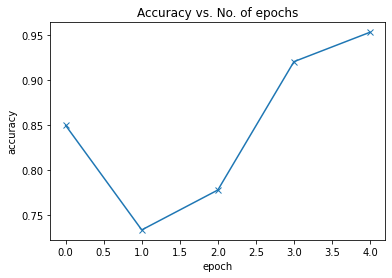

In [ ]:
plot_accuracies(history)

In [ ]:
torch.save(model.state_dict(), 'CNN_Model.pth')

In [ ]:
test_dataset = ImageFolder('/content/drive/MyDrive/CNN_Model/Test_Data', transform = ToTensor())

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.5302808284759521, 'val_acc': 0.41093751788139343}